# Recognizing UVA landmarks with neural nets


# Load Packages

In [0]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import torch.optim as optim
import torch
import torch.nn as nn
import torchvision
from torchvision import models

np.random.seed(49)

# Data Preprocessing and Augmentation

In [0]:
# Download dataset from Dropbox
!wget https://uvalandmark18.s3.amazonaws.com/UVALandmark18.zip

--2020-01-10 14:07:46--  https://uvalandmark18.s3.amazonaws.com/UVALandmark18.zip
Resolving uvalandmark18.s3.amazonaws.com (uvalandmark18.s3.amazonaws.com)... 52.216.110.251
Connecting to uvalandmark18.s3.amazonaws.com (uvalandmark18.s3.amazonaws.com)|52.216.110.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6194605880 (5.8G) [application/zip]
Saving to: ‘UVALandmark18.zip’

UVALandmark18.zip   100%[===================>]   5.77G  57.8MB/s    in 1m 43s  

2020-01-10 14:09:29 (57.2 MB/s) - ‘UVALandmark18.zip’ saved [6194605880/6194605880]



In [0]:
# Extract content
!unzip "/content/UVALandmark18.zip"

Archive:  /content/UVALandmark18.zip
warning [/content/UVALandmark18.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
   creating: UVALandmark18/
   creating: UVALandmark18/Academical Village/
  inflating: UVALandmark18/Academical Village/ks5qug:1574201282238  
  inflating: UVALandmark18/Academical Village/Mec2wr:1574176804076  
  inflating: UVALandmark18/Academical Village/jw6qs:1574027372543  
  inflating: UVALandmark18/Academical Village/jw6qs:1574027360247  
  inflating: UVALandmark18/Academical Village/Mec2wr:1574176408847  
  inflating: UVALandmark18/Academical Village/asz9qm:1574276428474  
  inflating: UVALandmark18/Academical Village/asz9qm:1574276517718  
  inflating: UVALandmark18/Academical Village/ANON:1574177114794  
  inflating: UVALandmark18/Academical Village/Mec2wr:1574176921561  
  inflating: UVALandmark18/Academical Village/.DS_St

In [0]:
from sklearn.datasets import load_files 
from keras.utils import np_utils
import  numpy as np
# define function to load train, test, and validation datasets
def load_dataset(path, num_classes):
    #Load text files with categories as subfolder names.
    data = load_files(path)
    filenames = np.array(data['filenames'])
    targets = np.array(data['target'])
    return filenames, targets

n_classes = 18;
class_names = ["Academical Village", "Thornton Hall", "Madison Hall", "Alumni Hall", "Olsson Hall", "New Cabell Hall", "University Chapel", "Newcomb Hall", "Rice Hall", "Old Cabell Hall", "Clark Hall", "Rotunda", "Bavaro Hall", "Minor Hall", "Aquatic & Fitness Center", "Scott Stadium", "Alderman Library", "Brooks Hall"]
# load train, test, and validation datasets
if os.path.isfile('/content/UVALandmark18/.DS_Store'): 
    os.remove('/content/UVALandmark18/.DS_Store')
root = '/content/UVALandmark18/'
for folder in os.listdir('/content/UVALandmark18/'):
  folder = root + folder
  for filename in os.listdir(folder):
    if '.DS_Store' in filename:
      os.remove(folder + '/' + filename)
files, targets = load_dataset('/content/UVALandmark18/',n_classes)
print(type(files), files)  

Using TensorFlow backend.


<class 'numpy.ndarray'> ['/content/UVALandmark18/Bavaro Hall/csn5aw:1573933936836'
 '/content/UVALandmark18/Brooks Hall/xy3jh :1574189685070'
 '/content/UVALandmark18/Olsson Hall/yl9gq:1574017354270' ...
 '/content/UVALandmark18/Madison Hall/ks5qug:1574201675326'
 '/content/UVALandmark18/Minor Hall/dbl3jf :1574194956314'
 '/content/UVALandmark18/Rice Hall/Jwh6ry :1574275138938']


In [0]:
from sklearn.model_selection import train_test_split
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=0.3, random_state=49)
train_files, val_files, train_targets, val_targets = train_test_split(train_files, train_targets, test_size=0.2, random_state=49)

In [0]:
import os
import pandas as pd

train = pd.DataFrame.from_dict({
    'filename': train_files,
    'category': train_targets
})

val = pd.DataFrame.from_dict({
    'filename': val_files,
    'category': val_targets
})

test = pd.DataFrame.from_dict({
    'filename': test_files,
    'category': test_targets
})

In [0]:
train.head()

,filename,category
0,/content/UVALandmark18/Thornton Hall/Sp3bk:157...,16
1,/content/UVALandmark18/Bavaro Hall/jk6nd:15742...,4
2,/content/UVALandmark18/Alderman Library/man9ej...,1
3,/content/UVALandmark18/Old Cabell Hall/mc6gb:1...,11
4,/content/UVALandmark18/New Cabell Hall/rb4nk:1...,9


In [0]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class UVALandmarks(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        image = Image.open(img_name)
        category = self.df.iloc[idx, 1]
        category = int(category)

        if self.transform:
            image = self.transform(image)

        return image, category

In [0]:
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomApply([transforms.RandomRotation(degrees=90)], p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Creating datasets 
train = UVALandmarks(df=train, transform=data_transforms['train'])
val = UVALandmarks(df=val, transform=data_transforms['val'])
test = UVALandmarks(df=test, transform=data_transforms['val'])

In [0]:
batch_size = 32
trainLoader = DataLoader(train, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(val, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)
testLoader = DataLoader(test, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)

x, y = iter(trainLoader).next()
print('batch-of-images: ', x.shape)
print('batch-of-labels: ', y.shape)

batch-of-images:  torch.Size([32, 3, 224, 224])
batch-of-labels:  torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


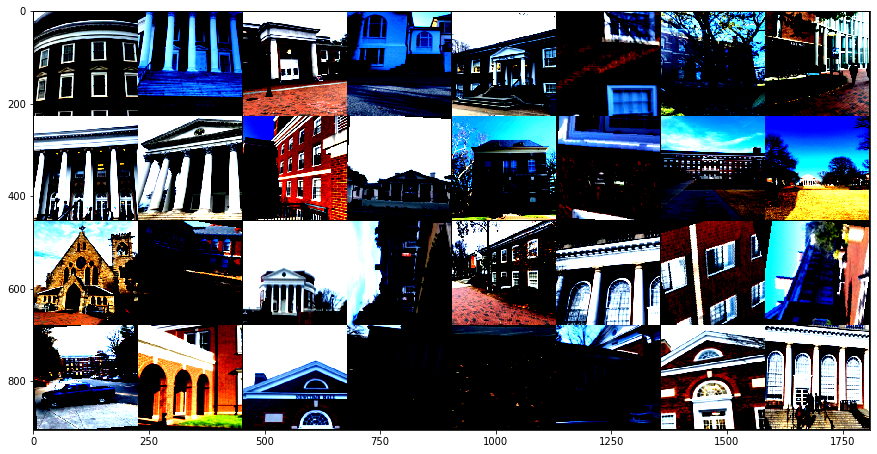

In [0]:
import torchvision
grid = torchvision.utils.make_grid(x)
plt.figure(figsize=(15,10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))

# Landmark Classification

In [0]:
def train_and_evaluate_model(model, criterion, optimizer,
                trainLoader, valLoader, n_epochs = 10, scheduler=None):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  training_accuracy = []
  training_loss = []
  validation_accuracy = []
  validation_loss = []

  for epoch in range(0, n_epochs):
    print('\nEpoch ', epoch+1)
    correct = 0
    cumloss = 0

    model.train()
    # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
      x, y = x.to(device), y.to(device)

      yhat = model(x)
      loss = criterion(yhat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        _, max_labels = yhat.max(1)   
        correct += (max_labels == y).sum().item() 
        cumloss += loss.item()
        
    n = len(train)
    train_accuracy = correct/n
    train_loss = cumloss/n
    training_accuracy.append(train_accuracy)
    print("Training Accuracy: ",  train_accuracy)
    training_loss.append(train_loss)
    print("Training Loss: ",  train_loss)

    correct = 0
    cumloss = 0
    model.eval()
    # Compute accuracy and loss on the validation set.
    with torch.no_grad(): 
      for (i, (x, y)) in enumerate(valLoader):
        x, y = x.to(device), y.to(device)
        
        yhat = model(x)
    
        _, max_labels = yhat.max(1)
        correct += (max_labels == y).sum().item()
        cumloss += loss.item()
    
    n = len(val)
    val_accuracy = correct/n
    val_loss = cumloss/n
    validation_accuracy.append(val_accuracy)
    print("Validation Accuracy: ",  val_accuracy)
    validation_loss.append(val_loss)
    print("Validation Loss: ",  val_loss)

    if scheduler is not None:
      scheduler.step(val_loss)

  # Evaluate on test set
  correct = 0
  with torch.no_grad(): 
    for (i, (x, y)) in enumerate(testLoader):

      yhat = model(x)
  
      _, max_labels = yhat.max(1)
      correct += (max_labels == y).sum().item()
  test_accuracy = correct/len(test)
  print('\nTest Accuracy: ', test_accuracy)

  epochs = list(range(n_epochs))
  fig = plt.figure(figsize = [15.0, 5.0])
  fig.subplots_adjust(hspace=.4, wspace=.4)
  fig.add_subplot(1,2,1)
  plt.plot(epochs, training_accuracy, label='Training Data')
  plt.plot(epochs, validation_accuracy, label = 'Validation Data')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')  
  plt.title('Epochs vs. Accuracy')
  plt.legend()
  fig.add_subplot(1,2,2)
  plt.plot(epochs, training_loss, label='Training Loss')
  plt.plot(epochs, validation_loss, label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')  
  plt.title('Epochs vs. Loss')
  plt.legend()

In [0]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(depthwise_separable_conv, self).__init__()
        self.pointwise = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        self.spatial = nn.Conv2d(output_channels, output_channels, kernel_size=3, 
                                   padding=1, groups=output_channels)

    def forward(self, x):
        out = self.pointwise(x)
        out = self.spatial(out)
        return out

In [0]:
resnet = models.resnet50(pretrained = True)
modules=list(resnet.children())[:-2]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.4MB/s]


In [0]:
custom_layers = nn.Sequential(
    depthwise_separable_conv(2048, 512),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    depthwise_separable_conv(512, 512),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    depthwise_separable_conv(512, 2048),
    nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ELU()
)

classification = nn.Sequential(
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(2048, 256),
    nn.Dropout(0.2),
    nn.Linear(256, 18)
)

In [0]:
# Glorot initializtion for linear layers
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)
classification.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Sequential(
  (0): AdaptiveAvgPool2d(output_size=(1, 1))
  (1): Flatten()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=256, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=256, out_features=18, bias=True)
)

In [0]:
myResNet = nn.Sequential(*modules, custom_layers, classification)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
myResNet = myResNet.to(device)

In [0]:
myResNet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
count_parameters(myResNet)


Epoch  1
Training Accuracy:  0.22157190635451504
Training Loss:  0.21711095958250423
Validation Accuracy:  0.33666666666666667
Validation Loss:  0.10577288468678793

Epoch  2
Training Accuracy:  0.451505016722408
Training Loss:  0.05979303965799784
Validation Accuracy:  0.5466666666666666
Validation Loss:  0.05392946799596151

Epoch  3
Training Accuracy:  0.5493311036789298
Training Loss:  0.049103529208081226
Validation Accuracy:  0.6166666666666667
Validation Loss:  0.04950277010599772

Epoch  4
Training Accuracy:  0.5811036789297659
Training Loss:  0.044916804219568056
Validation Accuracy:  0.71
Validation Loss:  0.055505303541819255

Epoch  5
Training Accuracy:  0.6923076923076923
Training Loss:  0.0334012178473648
Validation Accuracy:  0.75
Validation Loss:  0.03322746753692627

Epoch  6
Training Accuracy:  0.6463210702341137
Training Loss:  0.03898194840919214
Validation Accuracy:  0.55
Validation Loss:  0.07849778334299723

Epoch  7
Training Accuracy:  0.6630434782608695
Traini

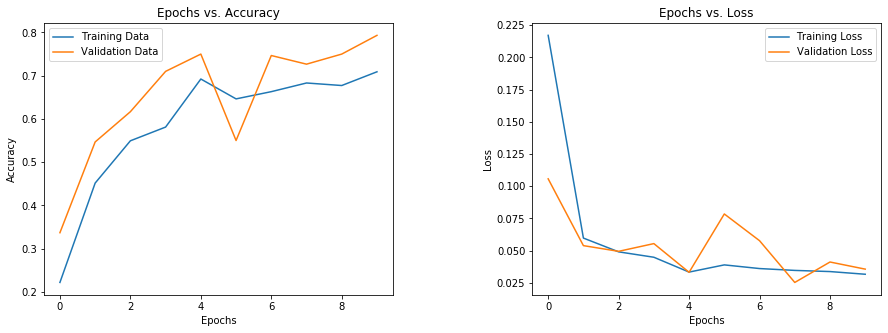

In [0]:
num_epochs = 10
learning_rate = 0.01
optimizer = optim.Adam(myResNet[8:].parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode='min')
criterion = nn.CrossEntropyLoss()
train_and_evaluate_model(myResNet, criterion, optimizer, trainLoader, valLoader, n_epochs = num_epochs, scheduler=scheduler)


Epoch  1
Training Accuracy:  0.5275919732441472
Training Loss:  0.053961730272474896
Validation Accuracy:  0.67
Validation Loss:  0.03440868457158407

Epoch  2
Training Accuracy:  0.7073578595317725
Training Loss:  0.03368339849554974
Validation Accuracy:  0.8533333333333334
Validation Loss:  0.07873224417368571

Epoch  3
Training Accuracy:  0.7508361204013378
Training Loss:  0.026171699789256157
Validation Accuracy:  0.8666666666666667
Validation Loss:  0.010609189669291178

Epoch  4
Training Accuracy:  0.7918060200668896
Training Loss:  0.022651889227505113
Validation Accuracy:  0.7366666666666667
Validation Loss:  0.04449456532796224

Epoch  5
Training Accuracy:  0.8135451505016722
Training Loss:  0.019984790164491405
Validation Accuracy:  0.8966666666666666
Validation Loss:  0.023423999547958374

Epoch  6
Training Accuracy:  0.8453177257525084
Training Loss:  0.016699842485695778
Validation Accuracy:  0.8666666666666667
Validation Loss:  0.008586687843004863

Epoch  7
Training Acc

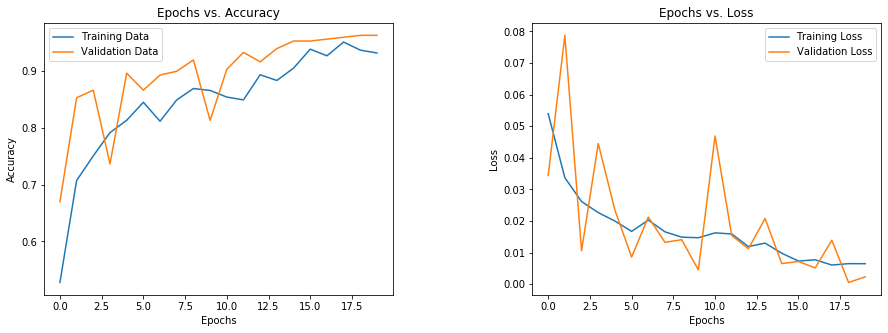

In [0]:
num_epochs = 20
learning_rate = learning_rate / 10
optimizer = optim.Adam(myResNet[6:].parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode='min')
criterion = nn.CrossEntropyLoss()
train_and_evaluate_model(myResNet, criterion, optimizer, trainLoader, valLoader, n_epochs = num_epochs, scheduler=scheduler)

In [0]:
def MCDO_test(model, n_classes):
    print('Start test')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()
    class_correct = list(0. for i in range(n_classes))
    class_total = list(0. for i in range(n_classes))
    with torch.no_grad():
        for data in valLoader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = 0
            for i in range(20):
                output += F.softmax(model(inputs)) / 20
            _, predicted = torch.max(output, 1)
            
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(n_classes):
        print('Accuracy of %5s : %.2f %%' % (
            class_names[i], 100 * class_correct[i] / class_total[i]))

    test_score = np.mean([100 * class_correct[i] / class_total[i] for i in range(n_classes)])
    print('{} %'.format(test_score))
    return test_score

In [0]:
MCDO_test(myResNet, 18)